# Continuous‑review (Q, R) Inventory System

This notebook implements the classical **continuous‑review (Q, R)**.

#### Assumption
- Inventory levels are known at all times.
- Demand is random but stationary with **rate** $\lambda$.
- There exists a positive **lead time** $\tau$.
- The costs:
  - **Set-up cost**: $K$ (per order).
  - **Per unit cost**: $c$.
  - **Holding cost**: $h$ (per unit held per unit time).
  - **Penalty cost**: $p$ (per unsatisfied demand).
- Unmet demand is **backlogged**.

#### Objective function: average annual cost:

\begin{aligned}
  G(Q,R) = h(\frac{Q}{2} + R-\mu) + \frac{K\lambda}{Q} + \frac{p\lambda n(R)}{Q}
\end{aligned}
where:
- $\mu=\lambda \tau$: the average demand over the lead time.
- $n(R)$: the expected number of stockouts (unfulfilled demand) per cycle.

\begin{gathered}
  n(R) = \sigma L(\cfrac{R-\mu}{\sigma}) = \sigma L(z) \\
  L(z) = \int^{\infty}_{z} (t-z) \phi(t) dt
\end{gathered}

#### Closed-loop solution (derived from the first-order optimality condition)

\begin{gathered}
  Q = \sqrt{\cfrac{2\lambda (K+pn(R))}{h}} \\
  1 - F(R) = \cfrac{Qh}{p\lambda}
\end{gathered}

#### Problem setting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

mu = 100
sigma = 25
c = 10
tau = 0.5
h = 0.2*10
p = 25
K = 50
lamb = 200

F = lambda R: norm.cdf(R, loc=mu, scale=sigma)
L = lambda z: norm.pdf(z) - z * (1 - norm.cdf(z))
n = lambda R: sigma*L((R-mu)/sigma)

eq1 = lambda R: np.sqrt(2 * lamb * (K + p * n(R)) / h)
eq2 = lambda R: p*lamb*(1-F(R))/h # as a function of Q

#### Plot of optimality conditions and the optimal solution

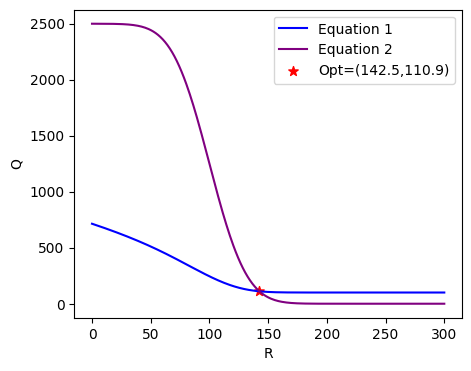

In [ ]:
R_array = np.linspace(0, 300, 300)
Q_array1 = eq1(R_array)
Q_array2 = eq2(R_array)

for i, R in enumerate(R_array):
    error = abs(Q_array1[i] - Q_array2[i])
    if error < 1:
        opt_R = R_array[i]
        opt_Q = Q_array1[i]
        break

plt.figure(figsize=(5,4))
plt.plot(R_array, Q_array1, c='blue', label="Equation 1")
plt.plot(R_array, Q_array2, c='purple', label="Equation 2")
plt.scatter(opt_R, opt_Q, marker='*', c='red', s=50, label=f'Opt=({opt_R:.1f},{opt_Q:.1f})') 
plt.ylabel("Q")
plt.xlabel("R")
plt.legend()
plt.show()

Both functions are highly nonlinear!

#### Fixed-point algorithm

In [3]:
Q0 = np.sqrt(2*K*lamb/h)
F_inv = lambda u: norm.ppf(u, loc=mu, scale=sigma)
R_cal = lambda Q: F_inv(1-Q*h/(p*lamb))

def iter_solution(eps = 0.5):
    Qs = [Q0]
    Rs = []

    Q = Q0
    itr = 0
    converge = False
    while not converge:
        R = R_cal(Q)
        Rs.append(R)
        if itr > 0:
            error_Q = abs(Qs[-2] - Qs[-1])
            error_R = abs(Rs[-2] - Rs[-1])

            if error_Q < eps and error_R < eps:
                converge = True
                break

        print(f'Iteration {itr}: ')
        print(f'\tQ = {Q:.1f}, R = {R:.1f}')
        
        Q = eq1(R)
        Qs.append(Q)
        
        itr += 1

    return Qs[-1], Rs[-1]

Q_opt, R_opt = iter_solution(eps = 0.1)

Iteration 0: 
	Q = 100.0, R = 143.8
Iteration 1: 
	Q = 109.6, R = 142.7
Iteration 2: 
	Q = 110.7, R = 142.6
Iteration 3: 
	Q = 110.8, R = 142.6


#### Visualization of the iterative solution

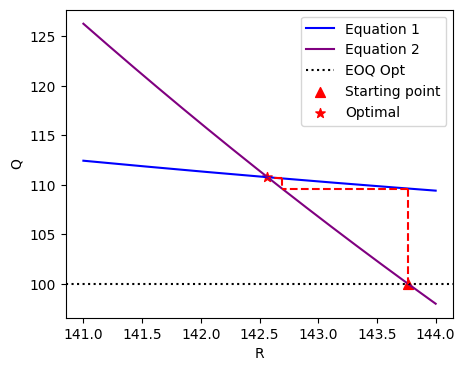

In [ ]:
R_array = np.linspace(141, 144, 200)
Q_array1 = eq1(R_array)
Q_array2 = eq2(R_array)

for i in range(200):
    error = abs(Q_array1[i] - Q_array2[i])
    if error < 0.1:
        opt_R = R_array[i]
        opt_Q = Q_array1[i]
        break

plt.figure(figsize=(5,4))
plt.plot(R_array, Q_array1, c='blue', label="Equation 1")
plt.plot(R_array, Q_array2, c='purple', label="Equation 2")

# start point
Q = Q0
for i in range(3): # 3 iterations
    if i == 0:
        plt.axhline(y=Q0, color='k', linestyle=':', label='EOQ Opt')
    else:
        R_prev = R
        R = R_cal(Q)
        plt.hlines(Q, R_prev, R, linestyles='--', colors='r')
    R = R_cal(Q)
    plt.vlines(R, eq1(R), eq2(R), linestyles='--', colors='r')
    Q = eq1(R)

start_Q = Q0
start_R = R_cal(Q0)

plt.scatter(start_R, start_Q, marker='^', c='red', s=50, label='Starting point')
plt.scatter(opt_R, opt_Q, marker='*', c='red', s=50, label=f'Optimal') 
plt.ylabel("Q")
plt.xlabel("R")
plt.legend()
# plt.savefig("solution.png", dpi=450)
plt.show()